# Моделирование нейрона на основе проводимости

## Введение

Большинство нейронов получают информацию через синапсы. Синапс состоит из пресинаптического окончания, синаптической щели и постсинаптического окончания. При поступлении потенциала действия на пресинаптическое окончание высвобождается нейротрансмиттер, который диффундирует через щель и активирует непосредственно или посредством ряда химических реакций ионные каналы, встроенные в мембрану постсинаптического окончания. Эти ионные каналы избирательно пропускают некоторые ионы через мембрану, тем самым увеличивая проводимость мембраны для этого иона.

В отличие от входов, основанных на токе, реакция на изменение проводимости зависит от мембранного потенциала. Это приводит к нескольким последствиям для динамики и возбудимости нейрона.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Нейронная модель

In [2]:
# Базовые единицы СИ 
s = 1
kg = 1
m = 1
A = 1

# производные единицы 
S = s**3*A**2/(kg*m**2)
V = kg*m**2*s**-3*A**-1
F = s**4 * A**2 * m**-2 * kg ** -1
Hz = 1/s

# с префиксами 
nS = 1e-9 * S
uS = 1e-6 * S
mV = 1e-3 * V
pF = 1e-12 * F
ms = 1e-3 * s

Теперь мы можем определить некоторые параметры, которые мы собираемся использовать с нашей моделью. Это включает в себя:

- шаг интегрирования по времени ( dt),
- реверсивные потенциалы ( E_l, E_e, E_i),
- проводимость утечки ( g_l),
- емкость мембраны ( C),
- пиковый порог ( threshold),
- потенциал сброса ( v_reset),
- рефрактерный период ( tau_ref)

In [3]:
dt = 0.01 * ms     # шаг интегрирования (мс)
E_e = 0*mV
E_i = -75*mV
E_l = -70*mV
g_l = 1./60*uS
C = 250*pF
v_reset = -60*mV
threshold = -50*mV
tau_ref = 2*ms

Мы собираемся смоделировать нейрон с помощью модели дырявого интегрирования и запуска (LIF). Это одномерное обыкновенное дифференциальное уравнение, определяющее эволюцию мембранного потенциала V:

$$
\frac{dV}{dt}=\frac{1}{C}[gL(El−V(t))+I(V,t)]
$$

Это модель идеализированного нейрона без дендритов и аксона, который часто называют точечным нейроном. Несмотря на свою простоту, он может уловить многие особенности ответов реальных нейронов.

Входные токи, представленныея I(V, t)в приведенном выше уравнении явно зависят как от мембранного потенциала V и время t. В нашем примере входные токи генерируются изменением проводимости, зависящей от времени g(t):

$$
I(V, t)=g(t)(E_r-V(t))
$$

еличина тока зависит от «движущей силы», то есть от разницы между мембранным потенциалом и потенциалом реверса $E_r-V(t)$. Для тормозных входов реверсивный потенциал более отрицателен, чем мембранный потенциал покоя $E_l$, тогда как для возбуждающих входов она более положительна; в обоих случаях проводимость положительна.

Как для тормозной, так и для возбуждающей проводимости полный ток принимает вид:

$$
I(V, t)=g_e(t)(E_e-V(t))+g_i(t)(E_i-V(t))
$$

Чтобы смоделировать всплеск, нам нужно искусственно ввести порог, выше которого генерируется всплеск. После спайка мы фиксируем мембранный потенциал до фиксированного значения ($V_{reset}$) на время рефрактерного периода ($τ_{ref}$).

Дискретизируем дифференциальное уравнение по времени и решаем его численно методом Эйлера:

$$
V_i=V_{i-1}+f(V_{i-1}, t_i)\Delta(t)
$$

где $f(V_{i-1}, t_i)$ является правой частью дифференциального уравнения.

Наконец, один шаг метода Эйлера можно реализовать следующим образом:

In [4]:
def _lif_update(v, refractory, ge, gi):
    if refractory:
        refractory -= 1
        v = v_reset
        return v, refractory
    v = v + (g_l * (E_l - v) +  
             ge * (E_e - v) + 
             gi * (E_i - v)) * dt / C
    if v > threshold:
        v = -45 * mV
        refractory = int(tau_ref/dt)
    return v, refractory

Эта функция принимает старый мембранный потенциал в качестве одного из своих аргументов и возвращает обновленный мембранный потенциал.

Комментарии :

- *Строка 1* : Для реализации рефрактерного периода мы ввели дополнительную переменную, refractoryкоторая увеличивается после каждого спайка на длину рефрактерного периода ( tau_ref) во временных шагах ( L11 ) и уменьшается на 1 после каждого шага, в течение которого нейрон является рефрактерным ( Л3 ).

- *L5-7* : Для простоты параметры модели передаются как глобальные переменные. Это может привести к проблемам при моделировании популяции нейронов LIF с разными параметрами. В этом случае было бы лучше обернуть функцию в класс или замыкание.

- *L10* : Хотя LIF не моделирует форму шипа, мы искусственно вводим «шип» для целей визуализации.

Чтобы получить полное решение, нам нужно инициализировать переменные и внедрить это обновление в цикл for:

In [5]:
def lif_run(g_e, g_i):
    n = np.minimum(len(g_e), len(g_i))
    v = np.zeros(n) * mV
    v[0] = E_l
    refractory = 0
    for i in range(1, n):
        v[i], refractory = _lif_update(v[i-1], refractory, g_e[i], g_i[i])
    return v

Комментарии:

- *L3* : мы создаем numpyмассив для хранения значений мембранного потенциала и инициализируем его всеми нулями,
- *L6-7* : основной цикл, в котором динамические переменные обновляются, а мембранный потенциал сохраняется в массиве на каждом временном шаге моделирования.

## Ответ на единичный спайк от возбуждающего нейрона

Теперь нам нужно определить кривую проводимости для стимуляции нейрона. Возьмем постсинаптическую проводимость (PSC) в форме альфа-функции:

In [6]:
def alpha_psp(a, tau, tmax=None):
    """Return alpha-function-shaped PSC
    Arguments:
    - a - amplitude
    - tau - time scale
    - tmax - duration (optional)
    """
    if tmax is None:
        tmax = 10 * tau
    time = np.arange(int(tmax / dt)) * dt
    return a * time / tau * np.exp(1 - time / tau)

Комментарии:

- L1 : Поскольку мы собираемся повторно использовать код альфа-функции, мы определяем его здесь как функцию трех параметров. Первые два определяют форму и ширину альфа-функции; последний контролирует общую длину возвращаемого массива.
- L8-9 : Если последний параметр не определен (он принимает значение по умолчанию None), мы устанавливаем его таким образом, чтобы альфа-функция была почти нулевой в конце трассы.

Мы выбираем возбуждающую проводимость, состоящую из одного PSC, начиная с 10 мс, и без тормозной проводимости:

In [7]:
g_e = np.r_[np.zeros(int(10*ms/dt)), alpha_psp(15*nS, 5*ms, 100*ms)]
g_i = np.zeros(len(g_e))

Теперь мы можем рассчитать мембранный потенциал (vmem) в зависимости от вышеуказанных проводимостей. Обратите внимание, что для получения правильного масштаба на графике мы должны преобразовать единицы измерения путем деления на выбранную единицу:

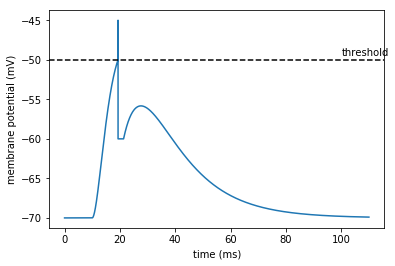

In [8]:
t = np.arange(len(g_e)) * dt
vmem = lif_run(g_e, g_i)
plt.plot(t / ms, vmem / mV)
plt.xlabel('time (ms)')
plt.ylabel('membrane potential (mV)')
plt.axhline(threshold/mV, ls='--', color='k')
plt.text(100, -49.5, 'threshold');

В ответ на PSC, начиная с 10 мс (стрелка), мембранный потенциал повышается до тех пор, пока не достигнет порогового значения (пунктирная линия) и не произойдет скачков. После скачков мембранный потенциал фиксируется на $v_{reset}$ на время рефрактерного периода. Когда рефрактерный период заканчивается, мембранный потенциал снова увеличивается, но на этот раз он не достигает порогового значения и быстро спадает до потенциала покоя в конце PSC.

Теперь мы увеличиваем возбуждающую и тормозящую проводимости на постоянные значения, но выбираем их таким образом, чтобы средний мембранный потенциал не менялся:

In [9]:
v = -70 * mV
gi_const = 10 * nS
ge_const = (-g_l * (E_l - v) - gi_const * (E_i - v)) / (E_e - v)
vmem_high_conductance = lif_run(g_e + ge_const, g_i + 10*nS)
plt.plot(t / ms, vmem / mV)
plt.plot(t / ms, vmem_high_conductance / mV)
plt.axhline(threshold/mV, ls='--', color='k')
plt.xlabel('time (ms)')
plt.ylabel('membrane potential (ms)');

Хотя изменение возбуждающей проводимости одинаковое, когда мы увеличиваем базовую тормозную и возбуждающую проводимость сбалансированным образом (мембранный потенциал покоя поддерживается постоянным, см. Первые 10 мс), увеличение мембранного потенциала меньше (зеленая кривая) и нейрон не испытывает скачков.

## Реакция под синаптической бомбардировкой

Теперь мы разработаем более реалистичный протокол стимуляции. В нормальных условиях in vivo нейрон получает постоянную синаптическую нагрузку от большого количества возбуждающих и тормозящих нейронов. Хотя общая частота поступающих импульсов может быть довольно большой, тормозящие и возбуждающие сигналы нейтрализуют друг друга, так что средний мембранный потенциал остается ниже порогового. Даже в этом случае увеличенная общая проводимость оказывает глубокое влияние на производительность, которую мы собираемся исследовать здесь.

Мы начнем с определения нескольких параметров, описывающих синаптические входные данные:

размеры PSC (tau_e и tau_i),
пиковые возбуждающие и тормозные проводимости (B_e и B_i),
общая частота срабатывания возбуждающих и тормозящих сигналов (fr_e и fr_i).

In [10]:
tmax = 10 * s        # время моделирования (ms)
tau_e = 0.2 * ms     # ширина возбуждающего PSC (ms)
tau_i = 2 * ms       # ширина тормозящего PSC (ms)
B_e = 7.1 * nS       # пиковая проводимость возбуждения (nS)
B_i = 3.7 * nS       # пиковая тормозная проводимость (nS)
fr_e = 9655 * Hz     # общая частота срабатывания возбудительной совокупности (Hz)
fr_i = 4473 * Hz     # общая частота срабатывания возбудительной совокупности (Hz)

Сначала мы генерируем и сохраняем следы тормозящих и возбуждающих PSC. Тормозящий PSC (показан синим цветом) меньше по амплитуде и шире:

In [11]:
epsp = alpha_psp(B_e, tau_e)
ipsp = alpha_psp(B_i, tau_i)

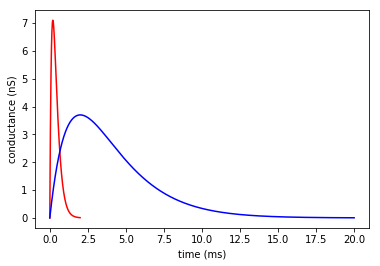

In [12]:
t = np.arange(len(epsp)) * dt
plt.plot(t / ms, epsp / nS, 'r-')
t = np.arange(len(ipsp)) * dt
plt.plot(t / ms, ipsp / nS, 'b-')
plt.xlabel('time (ms)')
plt.ylabel('conductance (nS)');

Теперь мы можем смоделировать эффекты синаптического сокращения тормозящими и возбуждающими нейронами. Мы предполагаем, что поступление спайков не коррелирует между нейронами. Кроме того, каждый нейрон вносит одинаковый вклад в изменение проводимости, как описано соответствующим PSC. При этом предположении время всплеска будет соответствовать так называемому пуассоновскому процессу. Самый простой способ сгенерировать случайную реализацию этого процесса - использовать приближение Бернулли, которое сводится к генерации серии случайных чисел из интервала [0,1] и проверке, является ли каждое из них меньше фиксированного порога, рассчитанного по частоте срабатывания. В этой реализации последовательность спайков разбита на ячейки, что означает, что она представлена двоичной последовательностью, где единица обозначает наличие спайка в конкретной ячейке. Для имитации такой последовательности скачков в Python мы можем использовать стандартный генератор случайных чисел. Например, для генерации последовательности скачков в 100 мс при частоте 100 Гц мы можем использовать следующий код:

([], <a list of 0 Text yticklabel objects>)

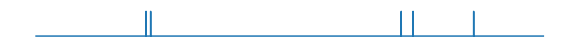

In [13]:
poisson_spikes = np.random.rand(int(100*ms/dt)) < 100 * Hz * dt
plt.figure(figsize=(10, 0.5))
plt.subplot(111, frameon=False)
plt.plot(poisson_spikes)
plt.xticks([])
plt.yticks([])

Чтобы сгенерировать общую трассировку проводимости, мы суммируем вклады от всех пресинаптических всплесков. Математически это может быть реализовано посредством свертки последовательности всплесков с помощью PSC:

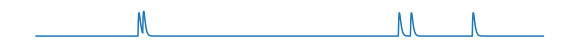

In [14]:
conductance_trace = np.convolve(poisson_spikes, epsp, 'valid')
plt.figure(figsize=(10, 0.5))
plt.subplot(111, frameon=False)
plt.plot(conductance_trace / nS)
plt.xticks([])
plt.yticks([]);

Такого рода процесс часто называют "шумом выстрела". Поскольку мы собираемся использовать его часто, мы можем инкапсулировать его в функцию:

In [15]:
def shot_noise(fr, kernel, tmax, dt):
    poisson_spikes = np.random.rand(int(tmax / dt)) < fr * dt
    shot_noise_trace = np.convolve(poisson_spikes, kernel, 'full')
    return shot_noise_trace[:len(poisson_spikes)]

Мы будем генерировать тормозные и возбуждающие трассы отдельно. Каждая трасса представляет собой комбинированный эффект всех пресинаптических всплесков от нейронов данного типа (возбуждающих или тормозящих, соответственно):

Text(0,0.5,'conductance (nS)')

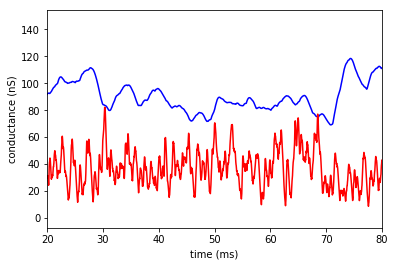

In [16]:
g_i = shot_noise(fr_i, ipsp, tmax, dt)
g_e = shot_noise(fr_e, epsp, tmax, dt)
t = np.arange(len(g_i)) * dt
plt.plot(t / ms, g_i / nS, 'b')
plt.plot(t / ms, g_e / nS, 'r')
plt.xlim([20, 80])
plt.xlabel('time (ms)')
plt.ylabel('conductance (nS)')

Теперь давайте смоделируем нейрон LIF с помощью этих трасс проводимости:

In [17]:
vmem = lif_run(g_e, g_i)

In [18]:
def estimate_firing_rate(vmem):
    return np.mean(vmem>threshold) / dt
def estimate_mean_free_pot(vmem):
    return np.mean(vmem[vmem<threshold])

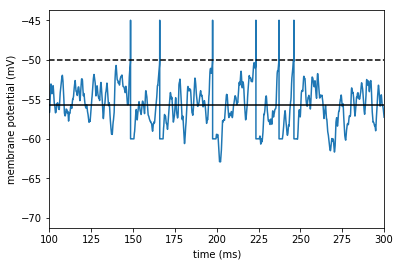

In [19]:
plt.plot(np.arange(len(vmem))*dt / ms, vmem / mV)
mean_pot = estimate_mean_free_pot(vmem)
plt.xlim([100, 300])
plt.axhline(threshold / mV, color='k', ls='--')
plt.axhline(mean_pot / mV, color='k')
plt.xlabel('time (ms)')
plt.ylabel('membrane potential (mV)');

Обратите внимание, что средний мембранный потенциал (сплошная горизонтальная линия) является подпороговым, то есть он остается ниже порога пикирования (пунктирная линия). Пики генерируются случайными колебаниями мембранного потенциала, превышающими пороговое значение. Величина этих колебаний зависит от величины и частоты этих колебаний, которые, в свою очередь, зависят от скорости срабатывания возбуждающих и тормозящих нейронов на входе. С одной стороны, более высокие частоты приведут к более быстрым флуктуациям и, следовательно, к большему количеству пересечений порога; с другой стороны, большее количество всплесков повысит общую проводимость мембраны и, таким образом, уменьшит величину отдельного постсинаптического потенциала (как мы наблюдали ранее для отдельных PSC). Чтобы увидеть, каково совместное действие этих двух противоположных сил, мы разработаем стимуляцию таким образом, чтобы возрастающая скорость возбуждения была уравновешена скоростью торможения, так что средний мембранный потенциал останется постоянным. Требуемая скорость торможения может быть рассчитана непосредственно на основе синаптических параметров, скорости возбуждения fe и целевого мембранного потенциала v:

In [20]:
def calc_fi(fe, v):
    e = np.exp(1)
    int_ge = tau_e * np.exp(1) * B_e
    int_gi = tau_i * np.exp(1) * B_i

    fi = -((E_e-v)*int_ge*fe+(E_l-v)*g_l)/((E_i-v)*int_gi)
    
    return fi

Мы запустим моделирование для разных скоростей возбуждения в цикле for, каждый раз записывая среднюю скорость возбуждения и средний мембранный потенциал в списках Python.

In [21]:
mean_free_pot = []
firing_rate = []
min_rate, max_rate = np.log10(1200) * Hz, 5 * Hz
n_points = 20
target_potential = -55 * mV
exc_rates = np.logspace(min_rate, max_rate, n_points)
for fe in exc_rates:
    fi = calc_fi(fe, target_potential)
    g_e = shot_noise(fe, epsp, tmax, dt)
    g_i = shot_noise(fi, ipsp, tmax, dt)
    vmem = lif_run(g_e, g_i)
    mean_free_pot.append(estimate_mean_free_pot(vmem))
    firing_rate.append(estimate_firing_rate(vmem))
firing_rate = np.array(firing_rate)
mean_free_pot = np.array(mean_free_pot)

Text(0.5,0,'excitatory firing rate (Hz)')

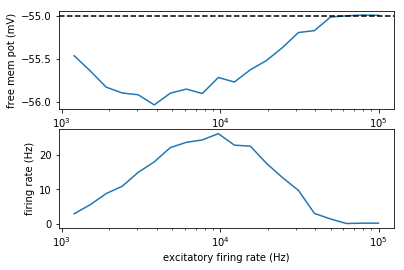

In [22]:
plt.subplot(211)
plt.semilogx(exc_rates, mean_free_pot / mV)
plt.axhline(target_potential / mV, color='k', ls='--')
plt.ylabel('free mem pot (mV)')
plt.subplot(212)
plt.semilogx(exc_rates, firing_rate / Hz)
plt.ylabel('firing rate (Hz)')
plt.xlabel('excitatory firing rate (Hz)')

Хотя средний мембранный потенциал почти постоянен — он изменяется не более чем на 2% от целевого потенциала (верхний график, пунктирная линия), — частота срабатывания изменяется немонотонно от 0 до 30 Гц. Эта немонотонная зависимость от частоты срабатывания входных данных будет иметь серьезные последствия для поведения рекуррентных сетей нейронов LIF, что наиболее примечательно, это позволит им быть постоянно активными без каких-либо внешних входов.